# Лабораторная работа №3. Деревья решений и ансамбли

**Работа выполнена**: Бактурин Савелий Филиппович M33331

**Преподаватель**: TBA.

## Инициализация

### Импорт библиотек

In [59]:
import optuna
import tqdm
import sklearn
import sklearn.neighbors
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import pandas
import numpy
import numpy.linalg
import matplotlib
import matplotlib.pyplot
import seaborn
import collections
import random
import copy
import math
from typing import List, Callable, Union, Tuple
from abc import ABC, abstractmethod

In [60]:
matplotlib.rcParams.update({'font.size': 14})

### Константные значения

In [61]:
from config import *

## Отчёт

### Набор данных

#### Загрузка данных

In [62]:
claims = pandas.read_csv(DATA_FILENAME, delimiter = DATA_DELIMITER)
claims = claims.drop(columns = ["ID", "Duration", "Net Sales", "Product Name", "Commision (in value)", "Distribution Channel"])

In [63]:
claims.head()

,Age,Agency,Agency Type,Destination,Gender,Claim
0,28,C2B,Airlines,SINGAPORE,F,1
1,37,JZI,Airlines,PHILIPPINES,F,0
2,27,EPX,Travel Agency,UNITED STATES,NaN,0
3,36,EPX,Travel Agency,SAUDI ARABIA,NaN,0
4,26,CWT,Travel Agency,THAILAND,NaN,0


In [64]:
claims.tail()

,Age,Agency,Agency Type,Destination,Gender,Claim
62283,36,EPX,Travel Agency,HONG KONG,NaN,0
62284,56,JZI,Airlines,AUSTRALIA,F,0
62285,36,EPX,Travel Agency,ITALY,NaN,1
62286,29,CWT,Travel Agency,AUSTRALIA,NaN,1
62287,44,EPX,Travel Agency,THAILAND,NaN,0


#### Обзор и первоначальная обработка

##### Вспомогательные функции

In [65]:
def draw_feature_countable(feature: str):
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.grid(True)
	seaborn.countplot(data = claims, y = feature, order = claims[feature].value_counts().index)
	matplotlib.pyplot.xlabel("N")
	matplotlib.pyplot.ylabel(feature)

In [66]:
def print_feature_counts(feature: str):
	for f, c in claims[feature].value_counts().to_dict().items():
		print(f, c)

In [67]:
def remove_all_category_except(category: str, excepted: List[str]):
	global claims
	mask = claims[category].isin(excepted)
	claims = claims[mask]

##### Категориальные переменные

###### Agency

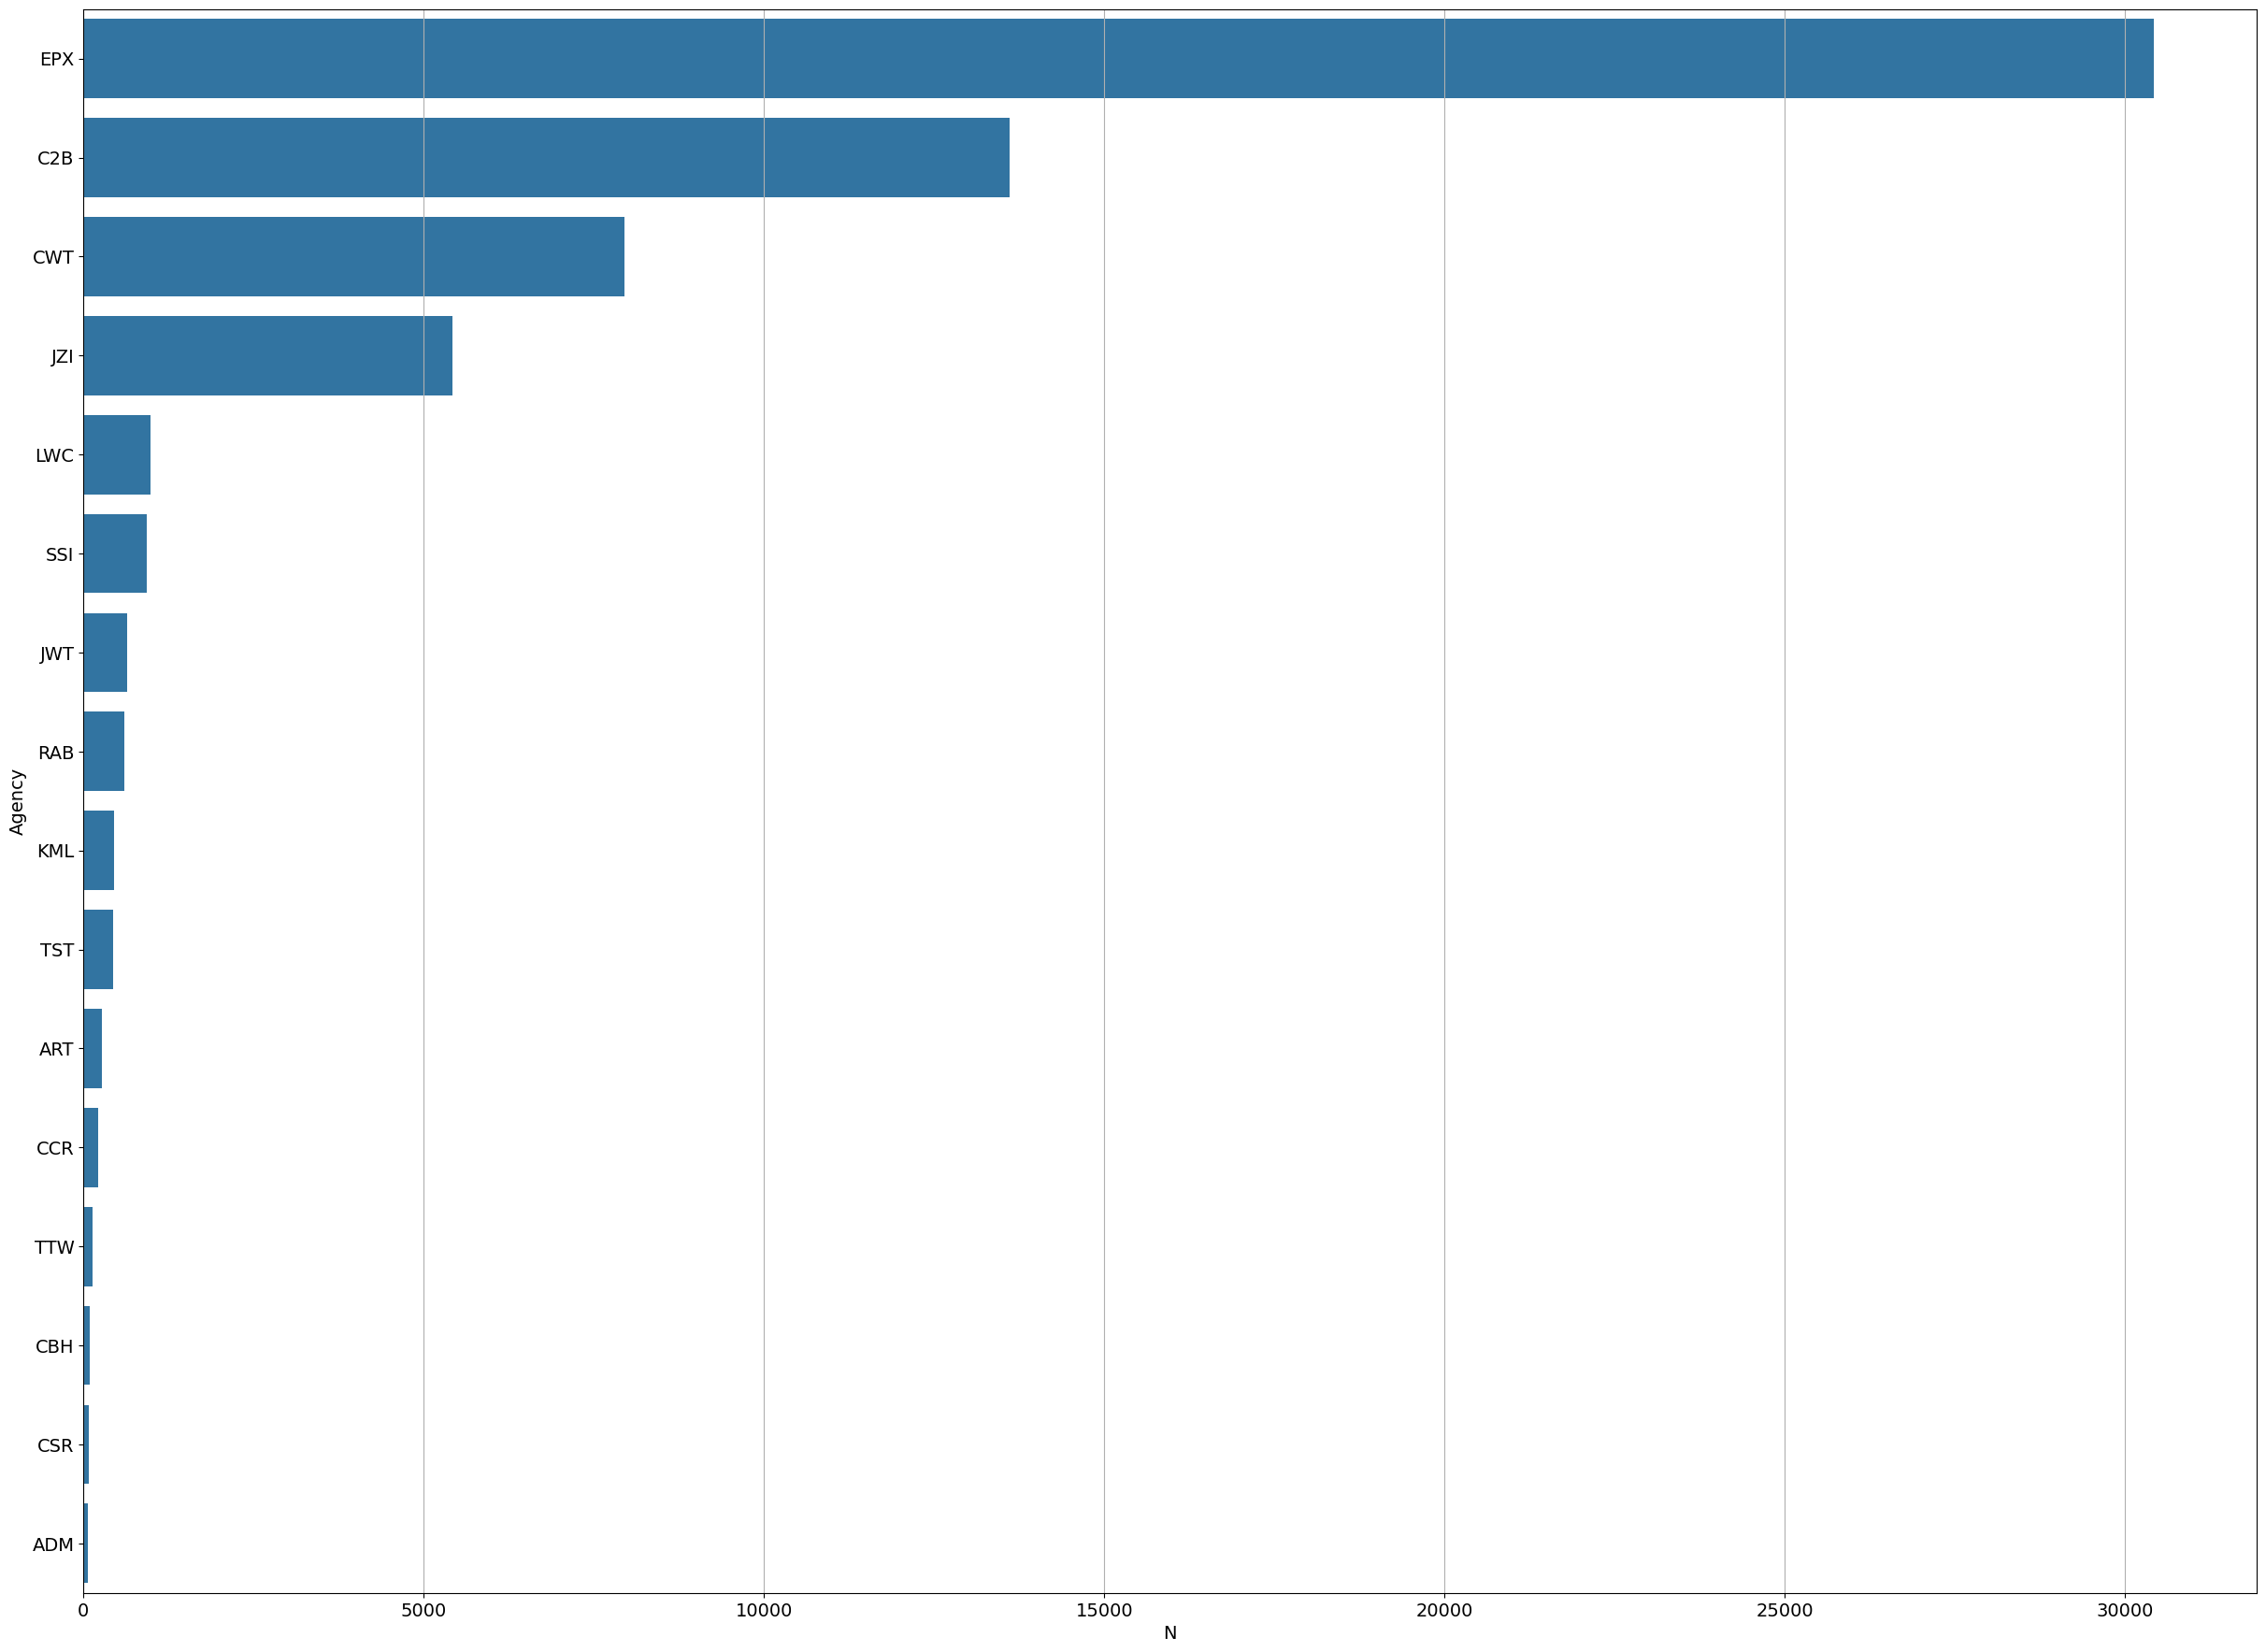

In [68]:
draw_feature_countable("Agency")

In [69]:
print_feature_counts("Agency")

EPX 30415
C2B 13608
CWT 7956
JZI 5416
LWC 980
SSI 935
JWT 639
RAB 603
KML 445
TST 440
ART 271
CCR 211
TTW 130
CBH 99
CSR 75
ADM 65


In [70]:
remove_all_category_except("Agency", ["EPX", "C2B", "CWT", "JZI", "SSI", "JWT", "LWC", "KML", "ART", "RAB"])

###### Destination

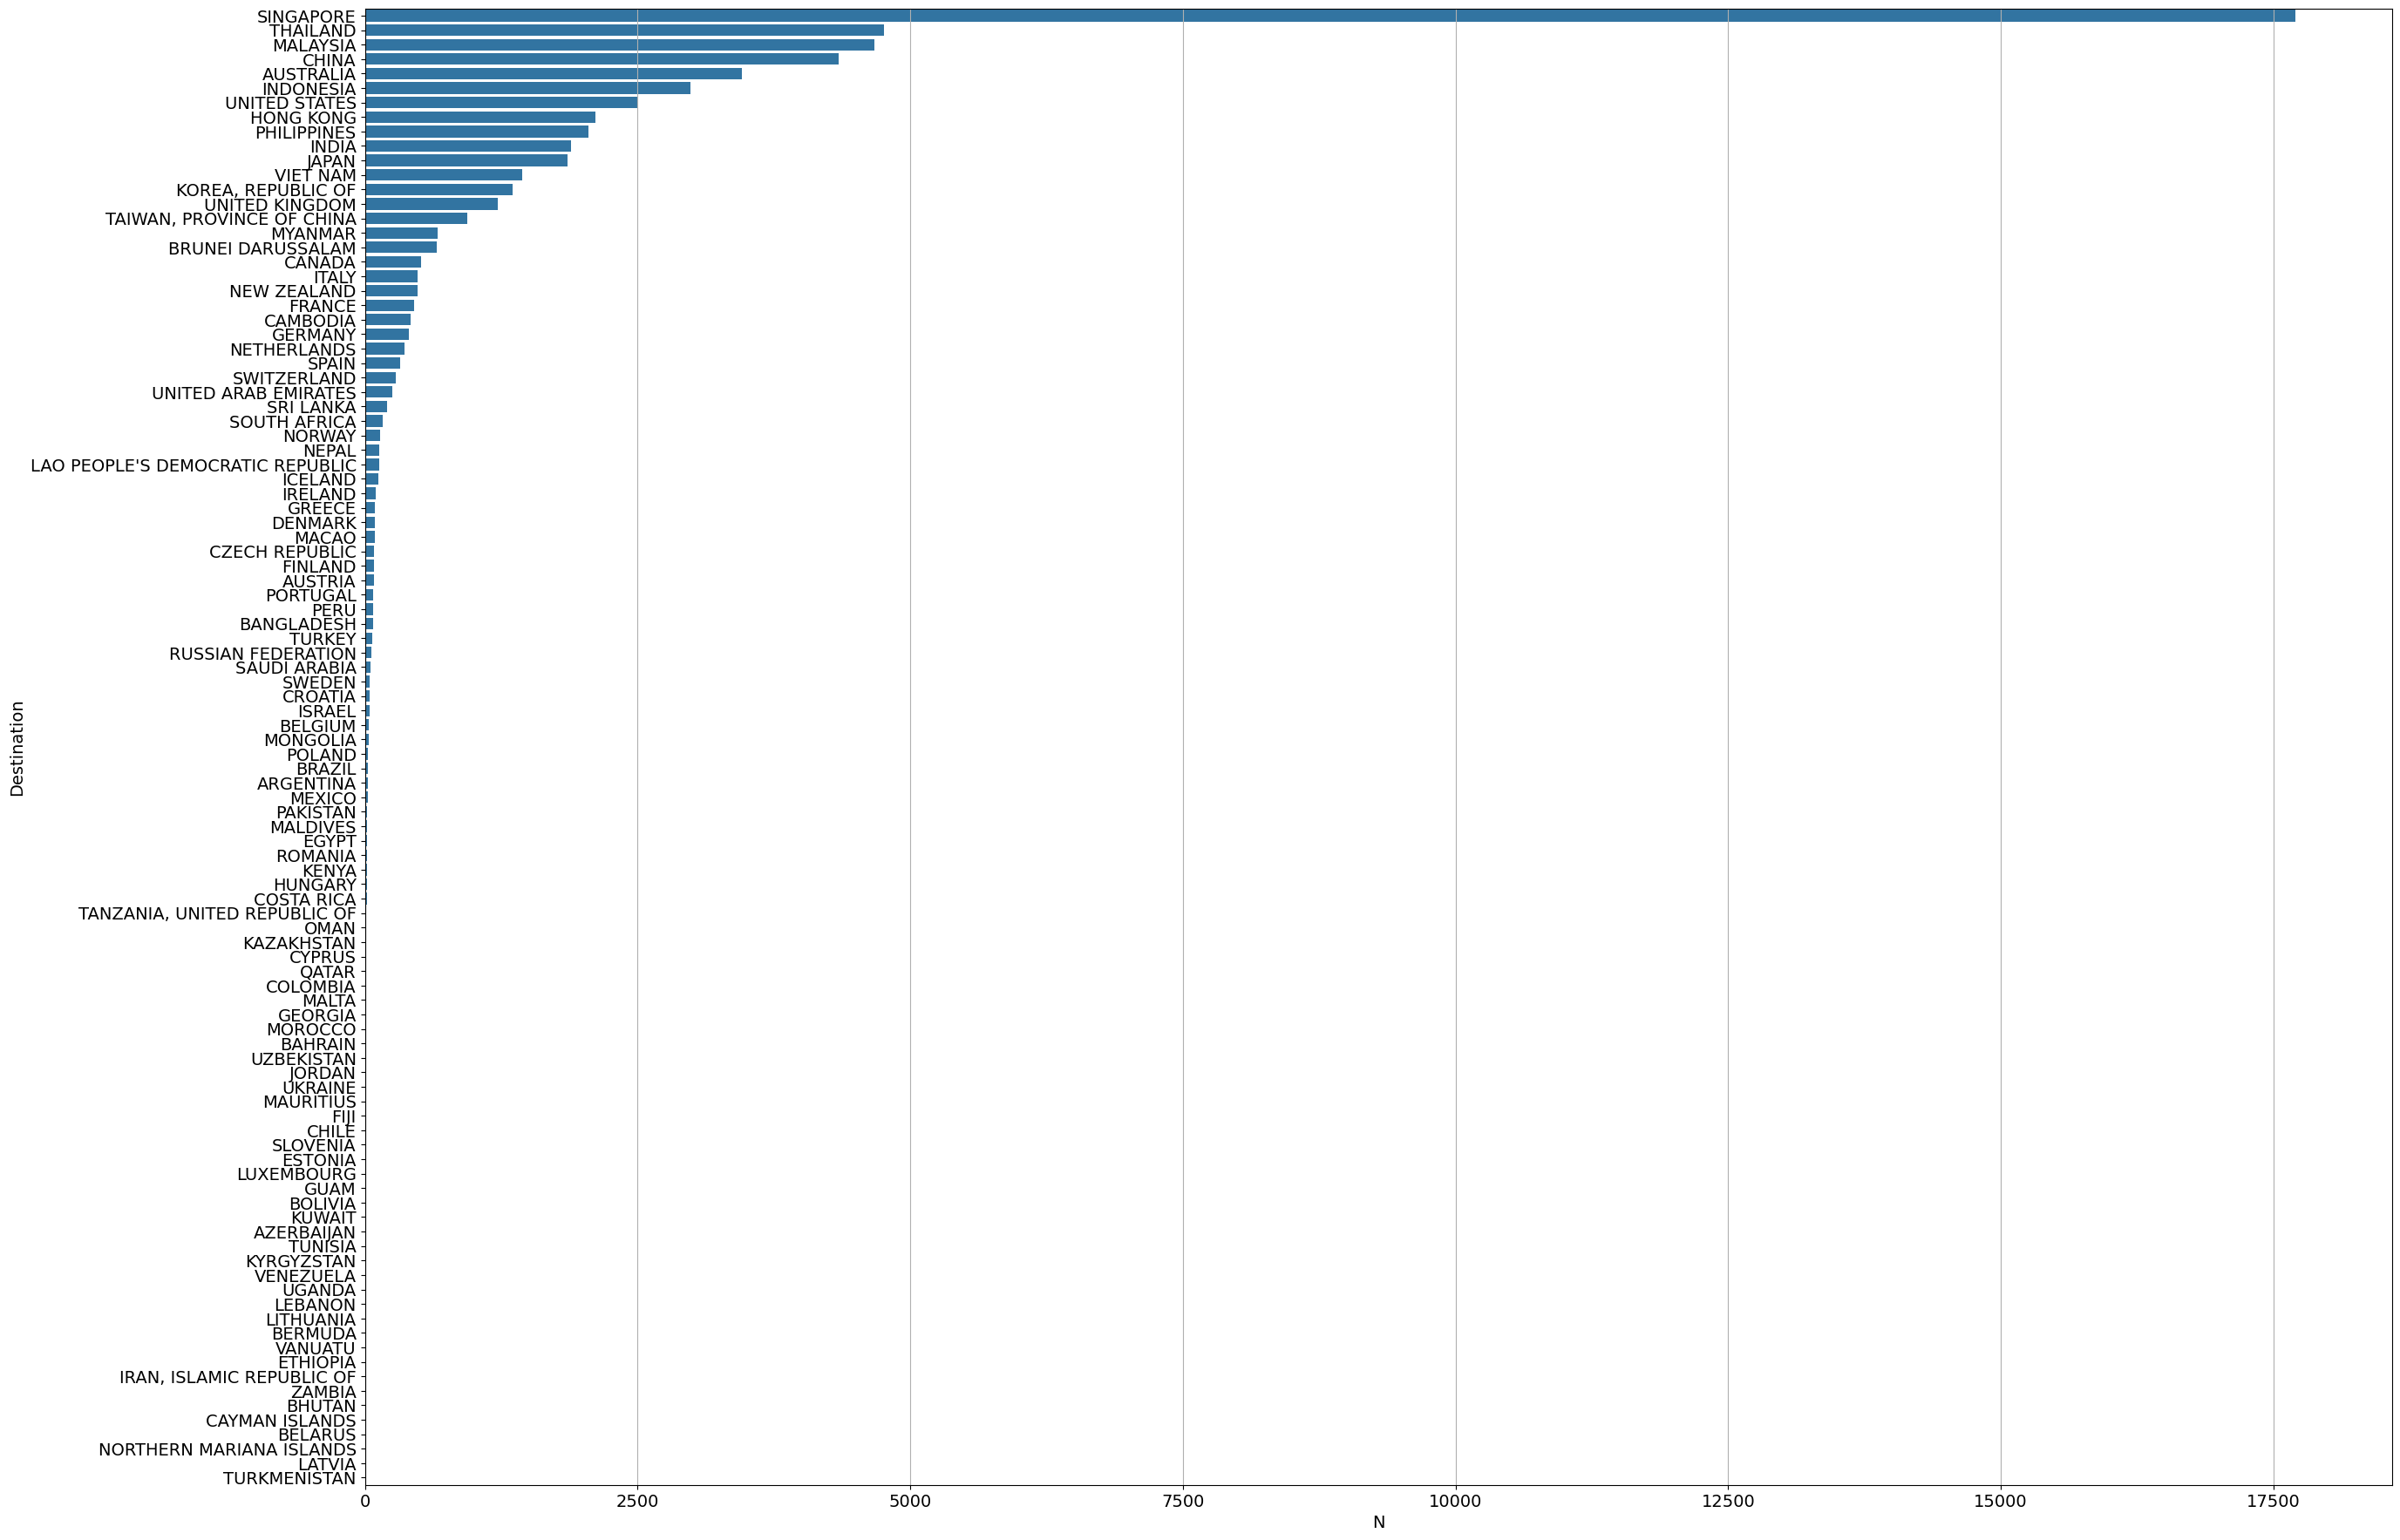

In [71]:
draw_feature_countable("Destination")

In [72]:
print_feature_counts("Destination")

SINGAPORE 17699
THAILAND 4763
MALAYSIA 4668
CHINA 4341
AUSTRALIA 3455
INDONESIA 2984
UNITED STATES 2508
HONG KONG 2115
PHILIPPINES 2051
INDIA 1887
JAPAN 1860
VIET NAM 1441
KOREA, REPUBLIC OF 1358
UNITED KINGDOM 1218
TAIWAN, PROVINCE OF CHINA 941
MYANMAR 671
BRUNEI DARUSSALAM 658
CANADA 513
ITALY 486
NEW ZEALAND 486
FRANCE 450
CAMBODIA 423
GERMANY 407
NETHERLANDS 366
SPAIN 327
SWITZERLAND 287
UNITED ARAB EMIRATES 255
SRI LANKA 201
SOUTH AFRICA 164
NORWAY 141
NEPAL 134
LAO PEOPLE'S DEMOCRATIC REPUBLIC 134
ICELAND 120
IRELAND 98
GREECE 95
DENMARK 91
MACAO 90
CZECH REPUBLIC 82
FINLAND 82
AUSTRIA 81
PORTUGAL 76
PERU 76
BANGLADESH 75
TURKEY 70
RUSSIAN FEDERATION 61
SAUDI ARABIA 51
SWEDEN 47
CROATIA 43
ISRAEL 42
BELGIUM 36
MONGOLIA 35
POLAND 30
BRAZIL 28
ARGENTINA 27
MEXICO 27
PAKISTAN 23
MALDIVES 20
EGYPT 19
ROMANIA 18
KENYA 18
HUNGARY 18
COSTA RICA 16
TANZANIA, UNITED REPUBLIC OF 15
OMAN 14
KAZAKHSTAN 13
CYPRUS 13
QATAR 13
COLOMBIA 12
MALTA 11
GEORGIA 11
MOROCCO 11
BAHRAIN 10
UZBEKISTAN 10


In [73]:
remove_all_category_except("Destination", ["SINGAPORE", "THAILAND", "MALAYSIA", "CHINA", "AUSTRALIA", "INDONESIA", "UNITED STATES", "HONG KONG", "PHILIPPINES", "INDIA", "JAPAN", "VIET NAM", "UNITED KINGDOM", "MYANMAR"])

In [74]:
print("Data size: %d" % (len(claims)))

Data size: 51661


#### Преобразования текстовых значений в числовые

In [75]:
def convert_str2num(num: str):
	return int(num)

In [76]:
for feat in FEATURES_NUMERIC:
	claims[feat] = claims[feat].apply(lambda x: convert_str2num(x) if isinstance(x, str) else x)

#### Преобразование категориальных переменных в числа

In [77]:
chandeliers_text_categories_indexes = {feat: {c: i for i, c in enumerate(claims[feat].unique())} for feat in FEATURES_TEXT}

In [78]:
chandeliers_text_categories_indexes

{'Agency': {'C2B': 0,
  'JZI': 1,
  'EPX': 2,
  'CWT': 3,
  'JWT': 4,
  'SSI': 5,
  'LWC': 6,
  'KML': 7,
  'ART': 8,
  'RAB': 9},
 'Agency Type': {'Airlines': 0, 'Travel Agency': 1},
 'Destination': {'SINGAPORE': 0,
  'PHILIPPINES': 1,
  'UNITED STATES': 2,
  'THAILAND': 3,
  'AUSTRALIA': 4,
  'HONG KONG': 5,
  'CHINA': 6,
  'UNITED KINGDOM': 7,
  'JAPAN': 8,
  'MALAYSIA': 9,
  'INDONESIA': 10,
  'INDIA': 11,
  'VIET NAM': 12,
  'MYANMAR': 13},
 'Gender': {'F': 0, nan: 1, 'M': 2}}

In [79]:
for feat in FEATURES_TEXT:
	claims[feat].replace(to_replace = chandeliers_text_categories_indexes[feat], inplace = True)

/tmp/ipykernel_73154/460819307.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  claims[feat].replace(to_replace = chandeliers_text_categories_indexes[feat], inplace = True)
/tmp/ipykernel_73154/460819307.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  claims[feat].replace(to_replace = chandel

In [80]:
claims.head()

,Age,Agency,Agency Type,Destination,Gender,Claim
0,28,0,0,0,0,1
1,37,1,0,1,0,0
2,27,2,1,2,1,0
4,26,3,1,3,1,0
5,39,3,1,4,1,0


In [81]:
claims.tail()

,Age,Agency,Agency Type,Destination,Gender,Claim
62282,31,3,1,4,1,0
62283,36,2,1,5,1,0
62284,56,1,0,4,0,0
62286,29,3,1,4,1,1
62287,44,2,1,3,1,0


#### Деление на `train`, `test` множества

In [82]:
target: List[List[float]] = []
features: List[int] = []

In [83]:
for _, row in claims.iterrows():
	collected_targets: List[float] = []
	for feat in FEATURES_ALL:
		if feat == TARGET_BIN_CLASS:
			if row[feat] == 0:
				features.append(-1)
			else:
				features.append(1)
		else:
			collected_targets.append(row[feat])
	target.append(collected_targets)

In [84]:
y_train, y_test, X_train, X_test = sklearn.model_selection.train_test_split(features, target, test_size = TEST_SIZE, random_state = RANDOM_STATE)

### Алгоритмы

In [85]:
def get_accuracy(actual: list, expected: List[int]) -> float:
	n = len(expected)
	passed = 0
	for i in range(n):
		if int(actual[i]) == expected[i]:
			passed += 1
	return passed / n

In [86]:
def get_error(actual: list, expected: List[int]) -> float:
	return 1.0 - get_accuracy(actual, expected)

#### Критерии

In [87]:
def entropy(ys: List[int], w: float = 1.0) -> float:
	et = sum(y >= 0 for y in ys) / len(ys)
	ef = sum(y < 0 for y in ys) / len(ys)
	ww = 0.0
	if et > 0.0:
		ww += et * math.log2(et)
	if ef > 0.0:
		ww += ef * math.log2(ef)
	return -w * ww

#### Дерево решений

In [88]:
class DTObject:
	def __init__(self, X: List[float], w: float = 1.0, y: int = -1):
		self.X = X
		self.weight = w
		self.y = y

In [89]:
class DTPredicate:
	def __init__(self, index: int, num: float):
		self.__index = index
		self.__num = num

	def apply(self, object: DTObject) -> bool:
		return object.X[self.__index] <= self.__num

In [90]:
class DTSample:
	def __init__(self, objects: List[DTObject] = None):
		self.__objects = []
		if objects:
			self.__objects = objects

	def __count_of(self, y: int) -> int:
		cnt = 0
		for object in self.__objects:
			if object.y == y:
				cnt += 1
		return cnt

	def add_object(self, object: DTObject):
		self.__objects.append(object)

	def count(self):
		return len(self.__objects)

	def apply_criteria(self, criteria: Callable[[List[int]], float], weights: List[float]) -> float:
		_, ws, ys = self.get_values()
		coef = sum(ws) / sum(weights)
		return criteria(ys, coef)

	def __get_objects(self) -> List[List[float]]:
		return [obj.X for obj in self.__objects]

	def __get_weights(self) -> List[float]:
		return [obj.weight for obj in self.__objects]

	def __get_classes(self) -> List[int]:
		return [obj.y for obj in self.__objects]

	@staticmethod
	def from_values(X: List[List[float]], y: List[float], w: List[int]) -> 'DTSample':
		xs = DTSample()
		for i in range(len(X)):
			xi = X[i]
			yi = y[i]
			wi = w[i]
			object = DTObject(xi, wi, yi)
			xs.add_object(object)
		return xs

	def get_values(self) -> Tuple[List[List[float]], List[float], List[int]]:
		return self.__get_objects(), self.__get_weights(), self.__get_classes()

	def find_max(self, y_min: int, y_max: int) -> int:
		cnt_max = -1
		y_answer = -1
		for y in range(y_min, y_max + 1):
			cnt = self.__count_of(y)
			if cnt > cnt_max:
				cnt_max = cnt
				y_answer = y
		return y_answer

In [153]:
class DTLeaf:
	def __init__(self, sample: DTSample):
		self.__sample = sample

	def predict(self, _: DTObject, y_min: int, y_max: int) -> int:
		return self.__sample.find_max(y_min, y_max)

	def get_depth(self) -> int:
		return 0

In [154]:
class DTNode:
	def __init__(self, predicate: DTPredicate = None, left: Union['DTNode', DTLeaf] = None, right: Union['DTNode', DTLeaf] = None):
		super().__init__()
		self.__left = left
		self.__right = right
		self.__predicate = predicate

	def predict(self, object: DTObject, y_min: int, y_max: int) -> int:
		if (self.__predicate.apply(object)):
			return self.__left.predict(object, y_min, y_max)
		else:
			return self.__right.predict(object, y_min, y_max)

	def get_depth(self) -> int:
		return 1 + max(self.__left.get_depth(), self.__right.get_depth())

	@staticmethod
	def fit(X: List[List[float]], y: List[int], weights: List[float], depth: int, min_samples_leaf: int, min_diff: float, criteria_fn: Callable[[List[List[float]]], List[float]], verbose: bool = False) -> Union['DTNode', DTLeaf]:
		if verbose:
			print("===> DTNode::fit\tdepth = %d" % (depth))

		x_sample = DTSample.from_values(X, y, weights)

		if len(X) < min_samples_leaf or depth == 0:
			if verbose:
				print("====> end with depth == 0 or min_samples_leaf (=%d) > len(X) (=%d)" % (min_samples_leaf, len(X)))
			return DTLeaf(x_sample)

		used = set()
		q = criteria_fn(y)
		q_diff_max = -float("inf")
		ls_max: DTSample = None
		rs_max: DTSample = None
		p_max: DTPredicate = None

		for xs in tqdm.tqdm(X):
			for i in range(len(xs)):
				x = xs[i]
				if x in used:
					continue
				used.add(x)
				p = DTPredicate(i, x)
				ls = DTSample()
				rs = DTSample()
				for i in range(len(X)):
					xi = X[i]
					wi = weights[i]
					yi = y[i]
					o = DTObject(xi, wi, yi)
					if p.apply(o):
						ls.add_object(o)
					else:
						rs.add_object(o)
				if ls.count() == 0 or rs.count() == 0:
					continue
				q_diff = q - ls.apply_criteria(criteria_fn, weights) - rs.apply_criteria(criteria_fn, weights)
				if q_diff > q_diff_max:
					q_diff_max = q_diff
					p_max = p
					ls_max = ls
					rs_max = rs

		if q_diff_max < min_diff:
			if verbose:
				print("====> end with min_diff (=%f) > q_diff_max (=%f)" % (min_diff, q_diff_max))
			return DTLeaf(x_sample)

		l_o, l_w, l_c = ls_max.get_values()
		r_o, r_w, r_c = rs_max.get_values()

		return DTNode(p_max, DTNode.fit(l_o, l_c, l_w, depth - 1, min_samples_leaf, min_diff, criteria_fn, verbose), DTNode.fit(r_o, r_c, r_w, depth - 1, min_samples_leaf, min_diff, criteria_fn, verbose))

In [93]:
class Algorithm(ABC):
	@abstractmethod
	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		pass

	@abstractmethod
	def predict(self, X: List[float]) -> int:
		pass

	@abstractmethod
	def predict_many(self, X: List[List[float]]) -> List[int]:
		pass

In [155]:
class DecisionTree(Algorithm):
	def __init__(self, criteria_fn: Callable[[List[List[float]], List[float]], float], max_depth: int = -1, min_samples_leaf: int = 100, min_diff: float = 0.001):
		self.__root: Union[DTLeaf, DTNode] = DTNode()
		self.__criteria_fn = criteria_fn
		self.__max_depth = max_depth
		self.__min_samples_leaf = min_samples_leaf
		self.__min_diff = min_diff
		self.__y_min = -1
		self.__y_max = -1
		self.__weights: List[float] = None

	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		if weights:
			self.__weights = weights
		else:
			self.__weights = [1.0 for _ in range(len(y))]
		self.__y_min = int(min(y))
		self.__y_max = int(max(y))
		self.__root = DTNode.fit(X, y, self.__weights, self.__max_depth, self.__min_samples_leaf, self.__min_diff, self.__criteria_fn)

	def get_depth(self) -> int:
		return self.__root.get_depth()

	def predict(self, X: List[float]) -> int:
		return self.__root.predict(DTObject(X), self.__y_min, self.__y_max)

	def predict_many(self, X: List[List[float]]) -> List[int]:
		return [self.predict(x) for x in X]

#### Бустинг

In [95]:
class Boosting(Algorithm):
	def __init__(self, algorithm: Algorithm, n_algorithms: int = 1):
		self.__algorithm = algorithm
		self.__n_algorithms = n_algorithms
		self.__algorithms = [copy.deepcopy(self.__algorithm) for _ in range(self.__n_algorithms)]
		self.__alphas = [0.0 for _ in range(self.__n_algorithms)]

	@staticmethod
	def __get_accuracy(y_actual: List[int], y_expected: List[int]) -> float:
		correct = 0
		for i in range(len(y_actual)):
			if y_actual[i] == y_expected[i]:
				correct += 1
		return correct / len(y_expected)

	@staticmethod
	def __get_as_sign(values: List[float]) -> List[int]:
		lst: List[int] = []
		for v in values:
			if v < 0.0:
				lst.append(-1)
			else:
				lst.append(1)
		return lst

	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		if weights:
			self.__weights = weights
		else:
			self.__weights = [1.0 for _ in range(len(y))]

		for i in range(self.__n_algorithms):
			self.__algorithms[i].fit(X, y, self.__weights)
			pred = self.__algorithms[i].predict_many(X)
			accuracy = self.__get_accuracy(pred, y)
			if accuracy == 1.0:
				self.__alphas[i] = 1.0
				continue
			error = 1.0 - accuracy
			self.__alphas[i] = 0.5 * numpy.log((1 - error) / error)
			w_temp = numpy.array(self.__weights) * numpy.exp(-1 * self.__alphas[i] * numpy.array(y) * numpy.array(self.__weights))
			self.__weights = w_temp.tolist()

	def predict(self, X: List[float]) -> int:
		return sum(self.__alphas[i] * self.__algorithms[i].predict(X) for i in range(self.__n_algorithms))

	def predict_many(self, X: List[List[float]]) -> List[int]:
		pred = self.__alphas[0] * numpy.array(self.__algorithms[0].predict_many(X))
		for i in range(1, self.__n_algorithms):
			pred += self.__alphas[i] * numpy.array(self.__algorithms[i].predict_many(X))
		return self.__get_as_sign(pred)

#### Случайный лес

In [96]:
class RandomForest(Algorithm):
	def __init__(self, criteria_fn: Callable[[List[List[float]], List[float]], float], max_depth: int = -1, min_samples_leaf: int = 1, min_diff: float = 0.1, n_estimators: int = 20):
		self.__criteria_fn = criteria_fn
		self.__max_depth = max_depth
		self.__min_samples_leaf = min_samples_leaf
		self.__n_estimators = n_estimators
		self.__min_diff = min_diff
		self.__forest = [
			DecisionTree(
				self.__criteria_fn, self.__max_depth, self.__min_samples_leaf, self.__min_diff
			) for _ in range(self.__n_estimators)
		]

	@staticmethod
	def __transform_list(lst: List[List[Tuple[List[float], int, float]]]) -> List[Tuple[List[List[float]], List[int], List[float]]]:
		new_lst = []
		for sub_lst in lst:
			new_sub_lst = []
			new_sub_lst2 = []
			new_sub_lst3 = []
			for item in sub_lst:
				new_sub_lst.append(item[0])
				new_sub_lst2.append(item[1])
				new_sub_lst3.append(item[2])
			new_lst.append((new_sub_lst, new_sub_lst2, new_sub_lst3))
		return new_lst


	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		if weights is None:
			weights = [1.0 for _ in range(len(X))]

		n = len(X)
		indices = list(range(n))
		random.shuffle(indices)

		random_objects: List[List[Tuple[List[float], int, float]]] = [[] for _ in range(self.__n_estimators)]

		for i in indices:
			random_objects[random.randint(0, self.__n_estimators - 1)].append((X[i], y[i], weights[i]))

		random_objects = self.__transform_list(random_objects)
		for i in range(self.__n_estimators):
			self.__forest[i].fit(random_objects[i][0], random_objects[i][1], random_objects[i][2])

	def predict(self, X: List[float]) -> int:
		classes = [tree.predict(X) for tree in self.__forest]
		return collections.Counter(classes).most_common(1)[0][0]

	def predict_many(self, X: List[List[float]]) -> List[int]:
		return [self.predict(x) for x in X]

#### Библиотечная обёртка

In [97]:
class DecisionTreeWrapper(Algorithm):
	def __init__(self, criterion: str = "entropy", max_depth: int = None, min_samples_leaf: int = 1):
		self.__model = sklearn.tree.DecisionTreeClassifier(criterion = criterion, min_samples_leaf = min_samples_leaf, max_depth = max_depth)

	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		if not weights:
			weights = [1.0 for _ in range(len(X))]
		self.__model.fit(X = numpy.array(X), y = numpy.array(y), sample_weight = numpy.array(weights))

	def predict(self, X: List[float]) -> int:
		pred = numpy.sign(self.__model.predict(X = numpy.array([X])))
		return pred.tolist()[0]

	def predict_many(self, X: List[List[float]]) -> List[int]:
		pred = numpy.sign(self.__model.predict(X = numpy.array(X)))
		return pred.tolist()

In [119]:
class BoostingWrapper(Algorithm):
	def __init__(self, estimator: sklearn.tree.DecisionTreeClassifier, n_algorithms: int = 1):
		self.__n_algorithms = n_algorithms
		self.__algorithm = estimator
		self.__model = sklearn.ensemble.AdaBoostClassifier(self.__algorithm, n_estimators = self.__n_algorithms, algorithm = "SAMME")

	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		if not weights:
			weights = [1.0 for _ in range(len(X))]
		self.__model.fit(numpy.array(X), numpy.array(y), numpy.array(weights))

	def predict(self, X: List[float]) -> int:
		pred = numpy.sign(self.__model.predict(X = numpy.array([X])))
		return pred.tolist()[0]

	def predict_many(self, X: List[List[float]]) -> List[int]:
		pred = numpy.sign(self.__model.predict(X = numpy.array(X)))
		return pred.tolist()

In [99]:
class RandomForestWrapper(Algorithm):
	def __init__(self, max_depth: int = None, min_samples_leaf: int = 1, n_estimators: int = 20):
		self.__max_depth = max_depth
		self.__min_samples_leaf = min_samples_leaf
		self.__n_estimators = n_estimators
		self.__model = sklearn.ensemble.RandomForestClassifier(n_estimators = self.__n_estimators, max_depth = self.__max_depth, min_samples_leaf = self.__min_samples_leaf)

	def fit(self, X: List[List[float]], y: List[int], weights: List[float] = None):
		if not weights:
			weights = [1.0 for _ in range(len(X))]
		self.__model.fit(numpy.array(X), numpy.array(y), numpy.array(weights))

	def predict(self, X: List[float]) -> int:
		pred = numpy.sign(self.__model.predict(X = numpy.array([X])))
		return pred.tolist()[0]

	def predict_many(self, X: List[List[float]]) -> List[int]:
		pred = numpy.sign(self.__model.predict(X = numpy.array(X)))
		return pred.tolist()

### Исследования

In [100]:
def draw_errors(param_name: str, errors_train: List[float], errors_test: List[float], errors_train_library: List[float], errors_test_library: List[float], params: Union[List[int], List[float]]):
	title = "Исследование ошибки от гиперпараметра"
	xlabel = param_name
	ylabel = "Ошибка предсказания"
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.title(title)
	matplotlib.pyplot.plot(params, errors_train, color = COLOR_SET_TRAIN, label = "Множество TRAIN")
	matplotlib.pyplot.plot(params, errors_test, color = COLOR_SET_TEST, label = "Множество TEST")
	matplotlib.pyplot.plot(params, errors_train_library, color = COLOR_SET_TRAIN_LIBRARY, label = "Множество TRAIN на библиотечной реализации")
	matplotlib.pyplot.plot(params, errors_test_library, color = COLOR_SET_TEST_LIBRARY, label = "Множество TEST на библиотечной реализации")
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

In [161]:
def draw_heights(param_name: str, heights: List[int], params: Union[List[int], List[float]]):
	title = "Исследование высоты дерева от гиперпараметра"
	xlabel = param_name
	ylabel = "Высота дерева"
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.title(title)
	matplotlib.pyplot.plot(params, heights, color = "orange", label = "Высота")
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

#### Максимальная высота

In [157]:
min_samples_leafs = list(range(1, 100))
min_diffs = numpy.arange(0.00001, 0.001, 0.00005)

In [158]:
heights: List[int] = []

In [159]:
for msl in tqdm.tqdm(min_samples_leafs):
	model = DecisionTree(entropy, min_samples_leaf = msl)
	model.fit(X_train, y_train)
	heights.append(model.get_depth())

  2%|▏         | 131/6206 [00:00<00:25, 237.32it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcc00a7d8a0>>
Traceback (most recent call last):
  File "/home/saveliy-vm/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
100%|██████████| 320/320 [00:00<00:00, 33159.83it/s]


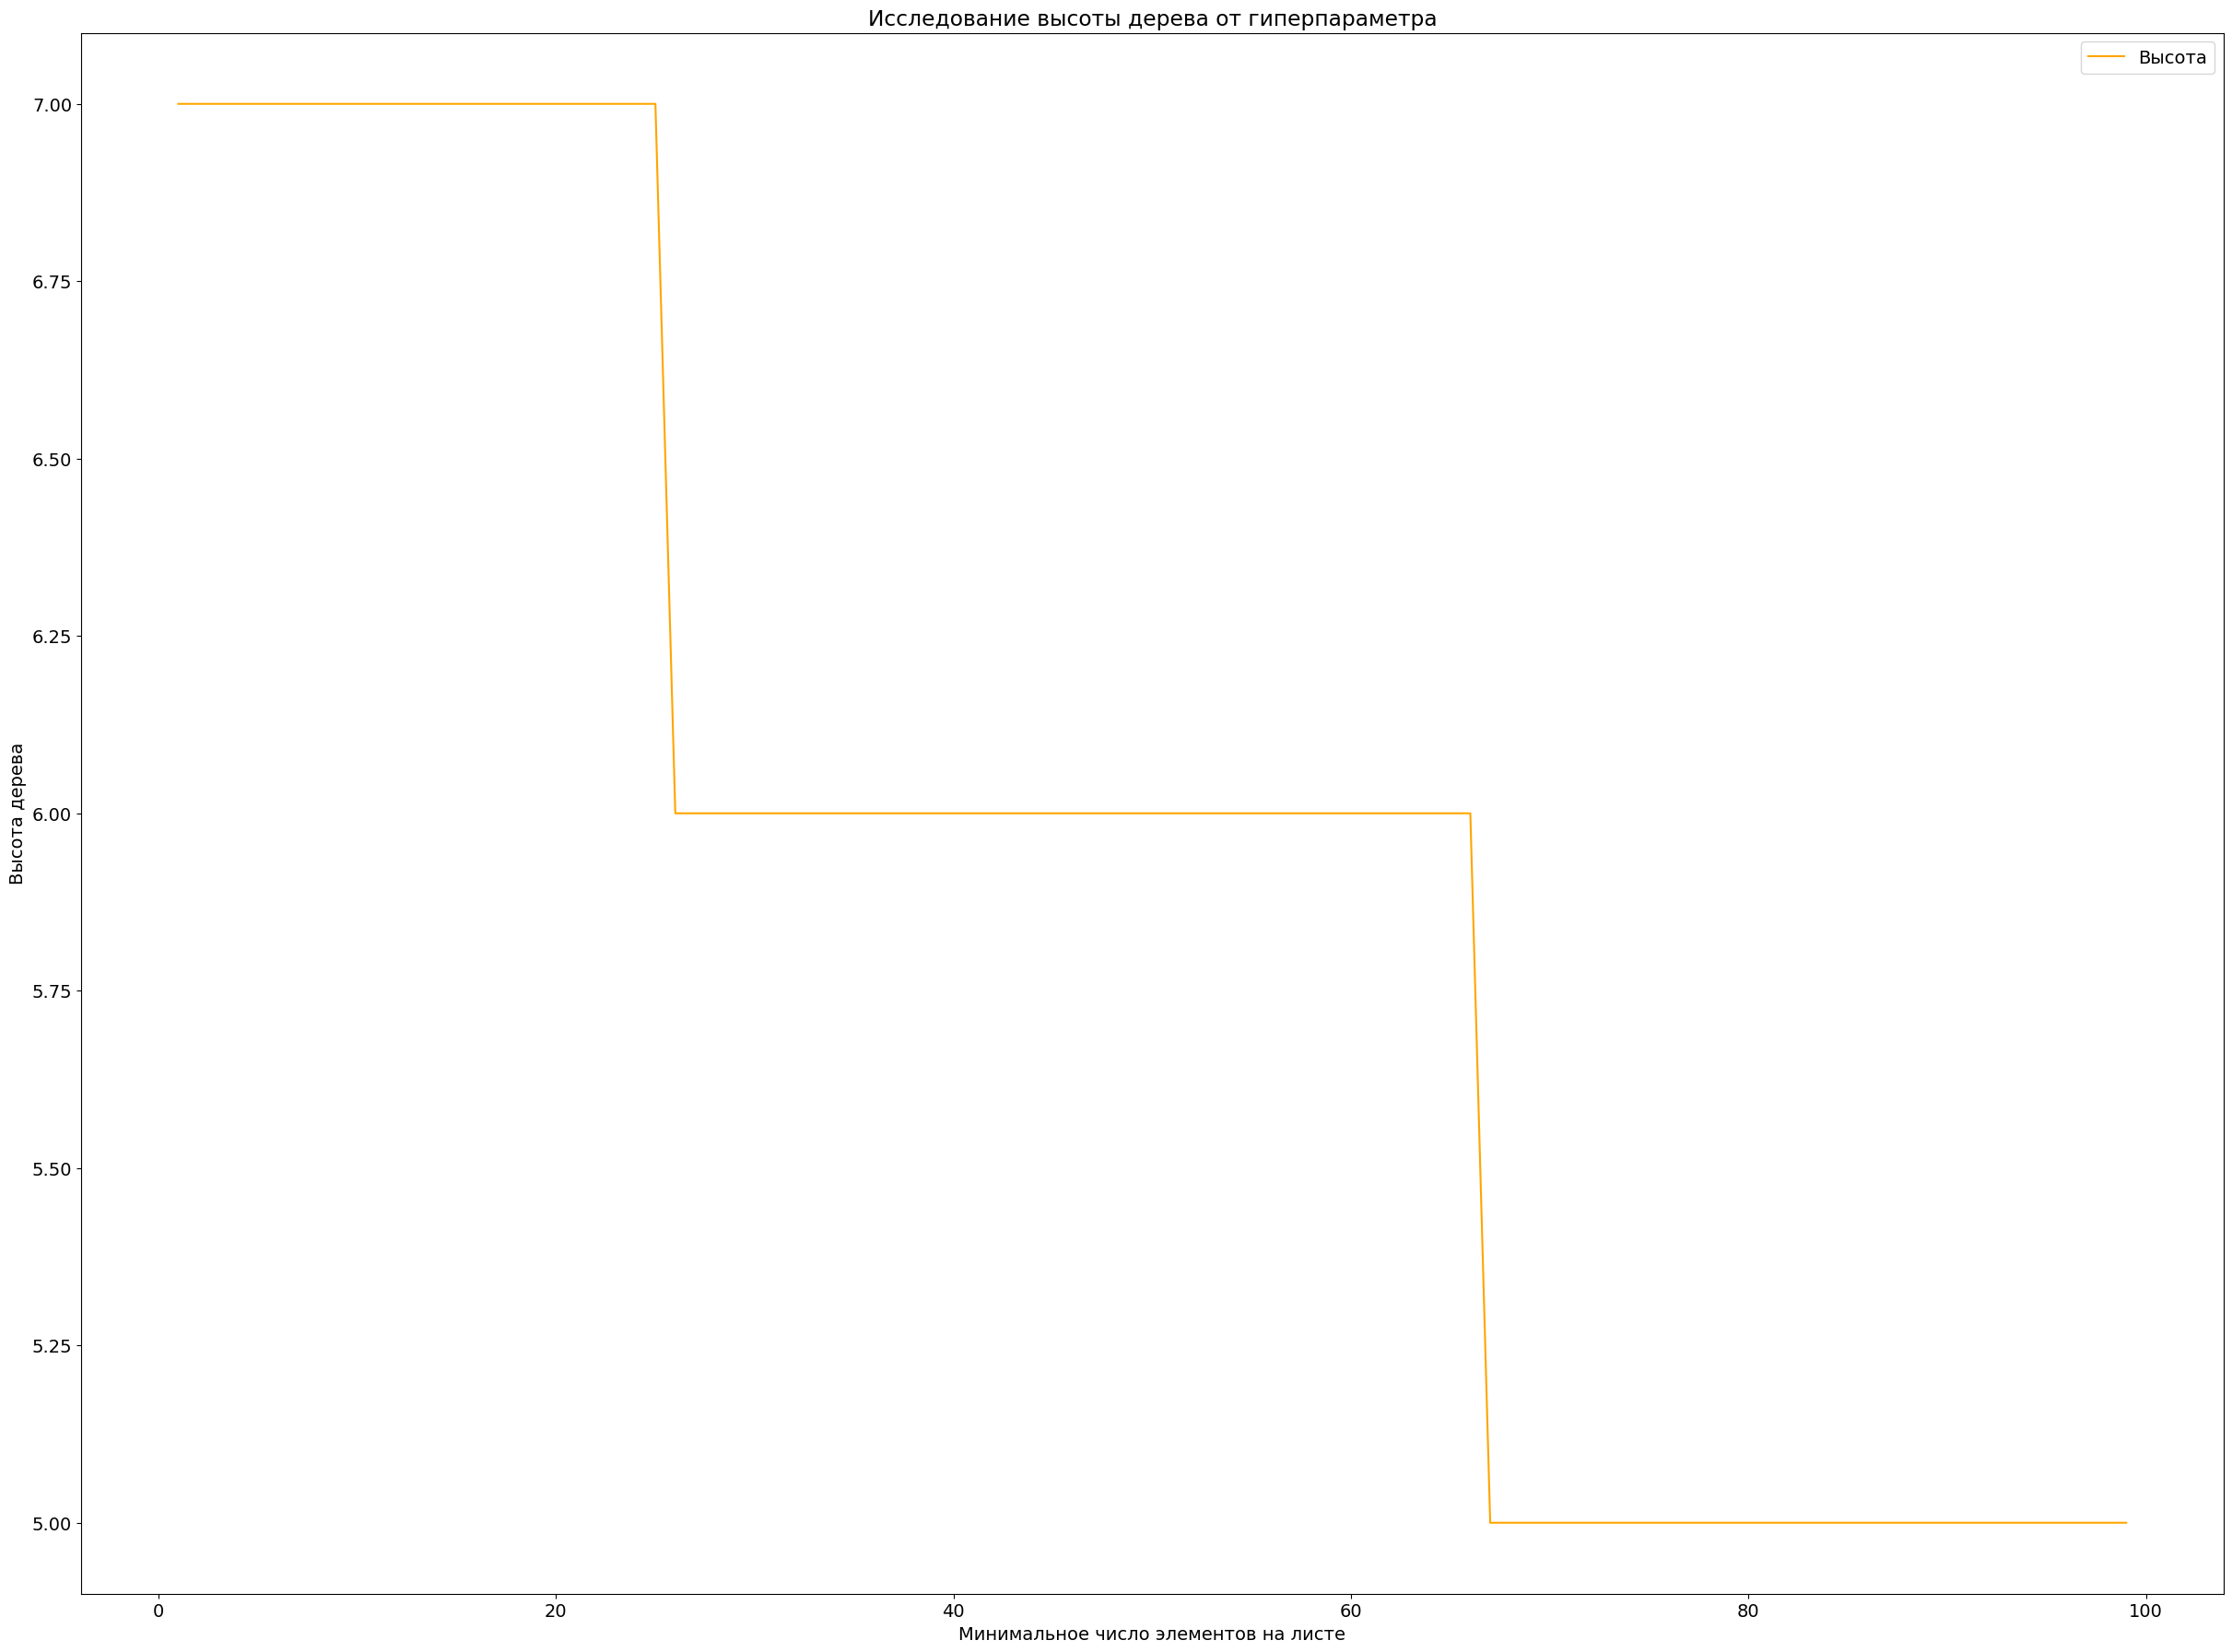

In [162]:
draw_heights("Минимальное число элементов на листе", heights, min_samples_leafs)

In [163]:
heights = []

In [164]:
for md in tqdm.tqdm(min_diffs):
	model = DecisionTree(entropy, min_diff = md)
	model.fit(X_train, y_train)
	heights.append(model.get_depth())

100%|██████████| 2/2 [00:45<00:00, 22.50s/it]


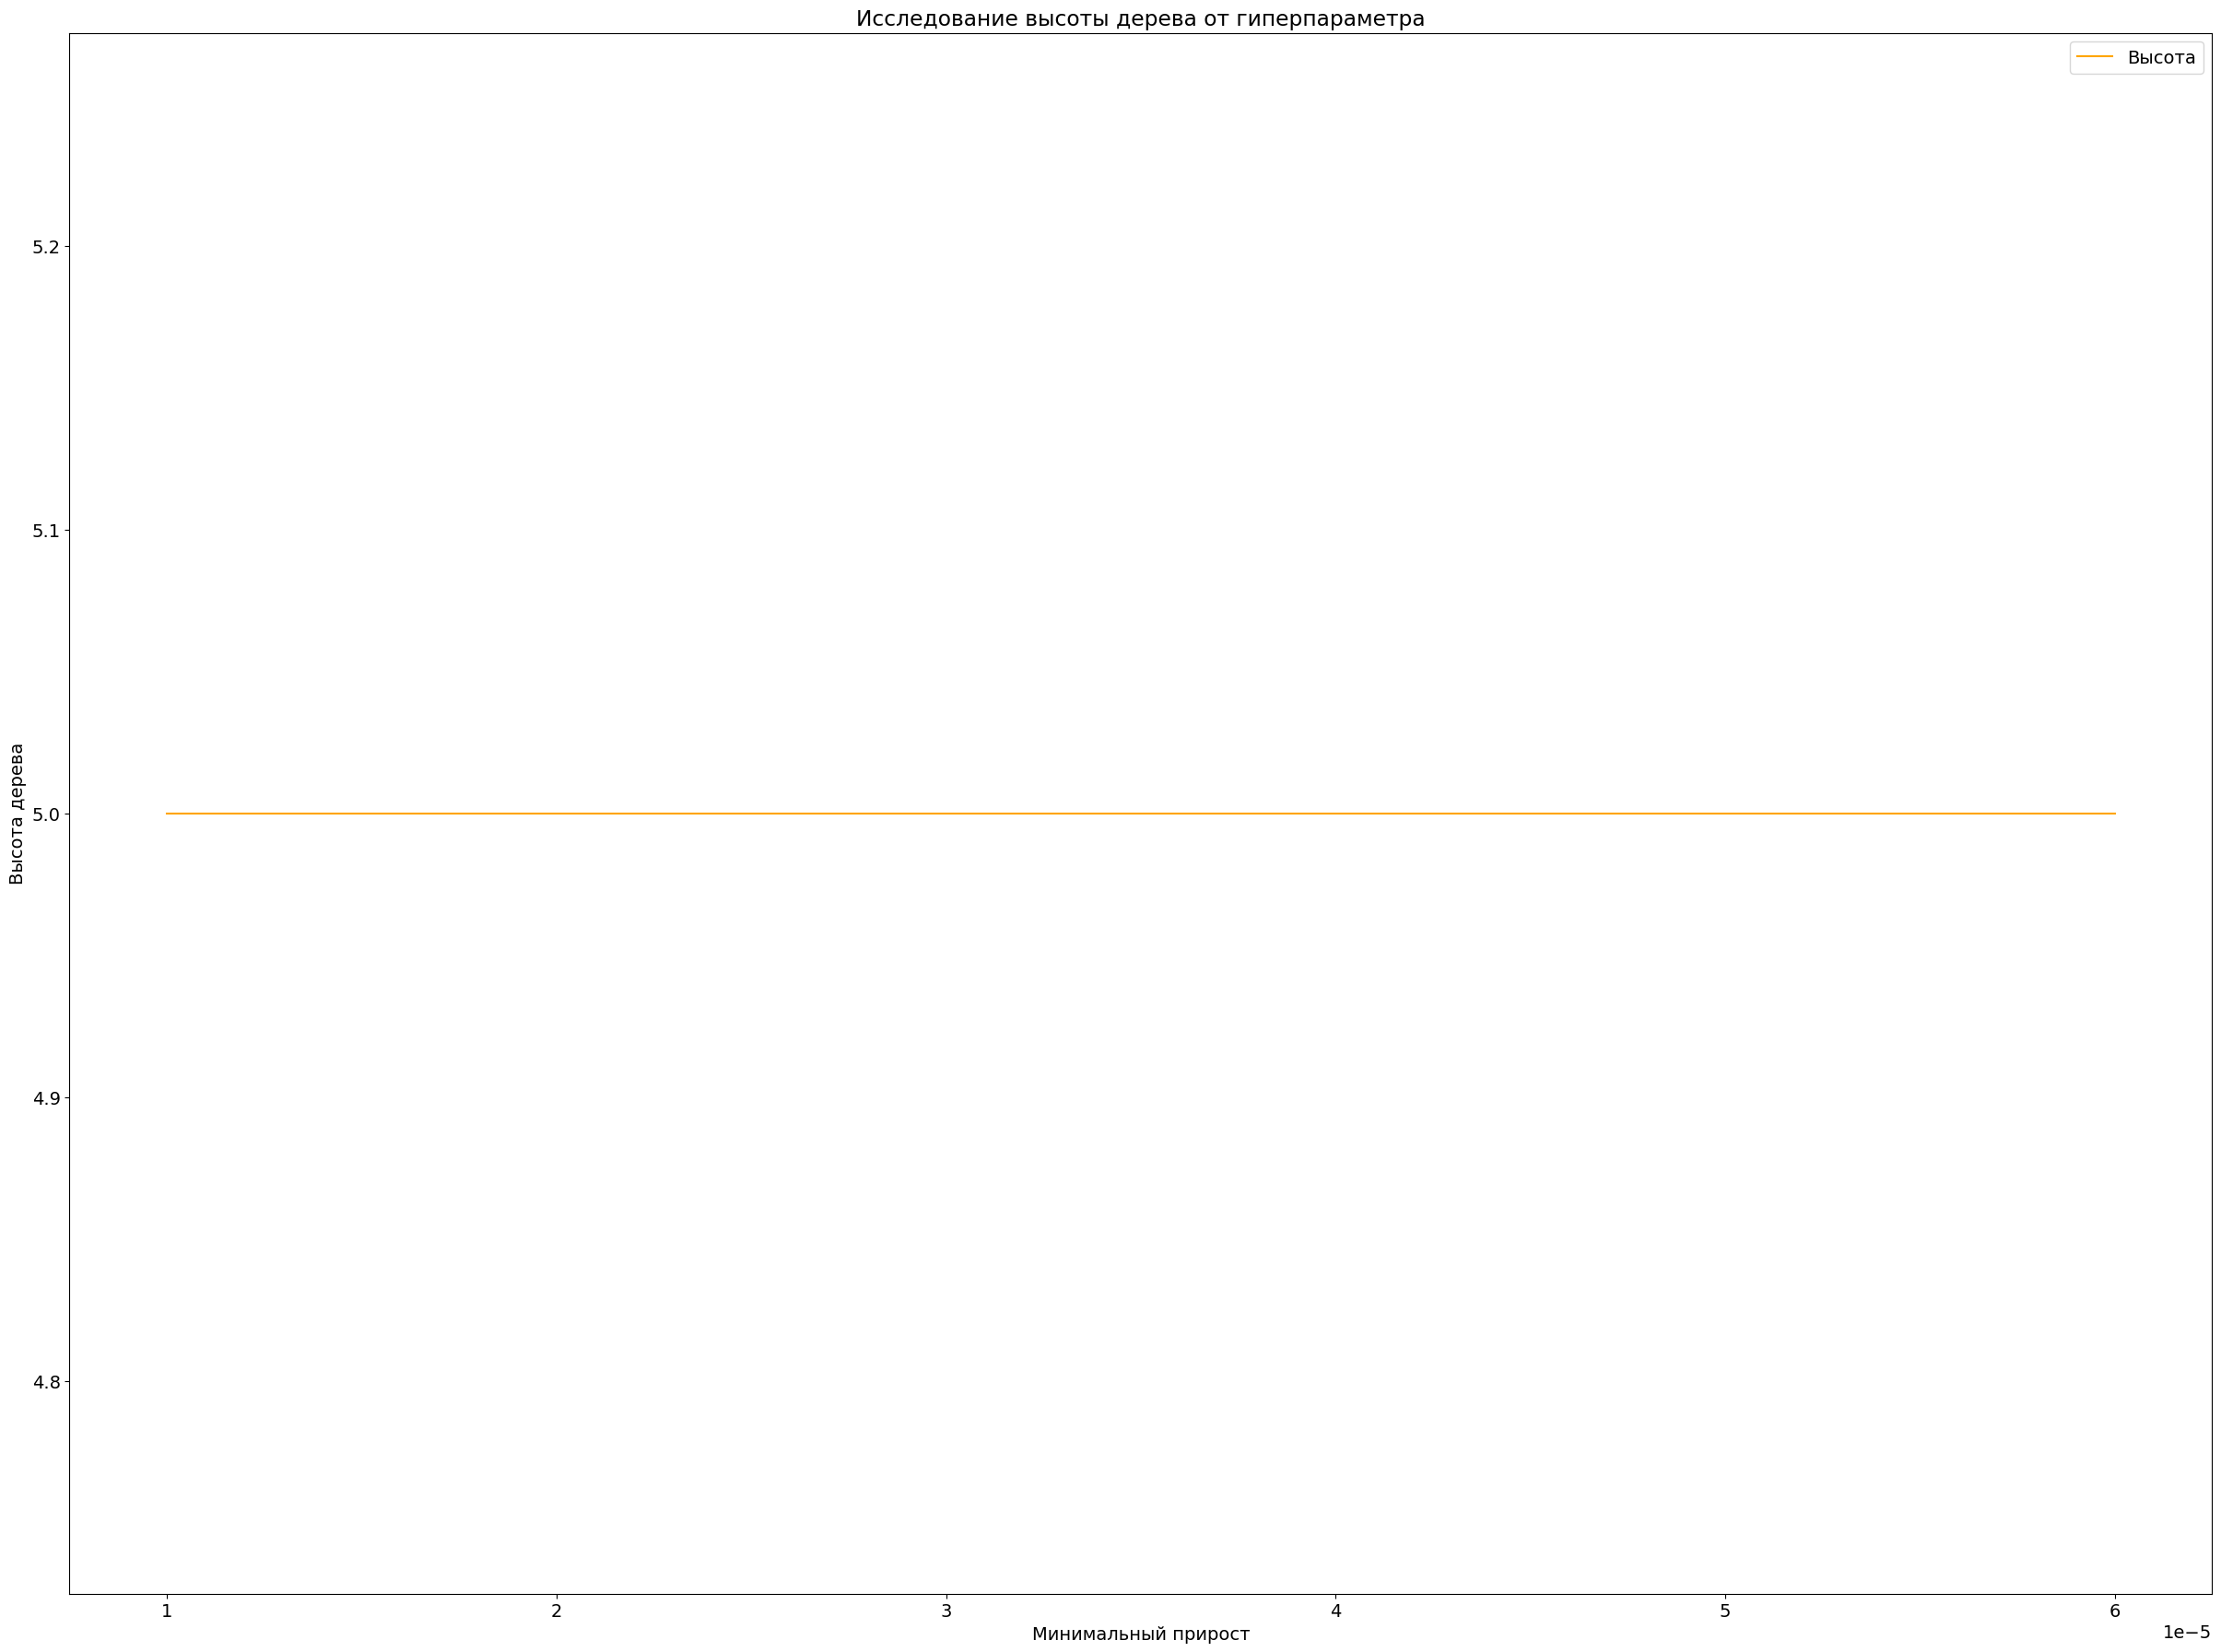

In [165]:
draw_heights("Минимальный прирост", heights, min_diffs)

#### Лучшие параметры для дерева решений

##### Библиотечная реализация

In [108]:
def objective(trial: optuna.Trial) -> float:
	criterion = trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"])
	max_depth = trial.suggest_int("max_depth", 1, 20)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
	model = DecisionTreeWrapper(criterion, max_depth, min_samples_leaf)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return sklearn.metrics.accuracy_score(y_test, pred)

In [109]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = OPTUNA_STUDY_N_TRIALS)

[I 2024-06-02 22:05:45,136] A new study created in memory with name: no-name-55e68417-5d8e-4f6e-9050-96a6358b589c
[I 2024-06-02 22:05:45,183] Trial 0 finished with value: 1.0 and parameters: {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 30}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:05:45,223] Trial 1 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 34}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:05:45,262] Trial 2 finished with value: 0.9779820953302686 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 64}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:05:45,299] Trial 3 finished with value: 1.0 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_leaf': 39}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:05:45,339] Trial 4 finished with value: 1.0 and parameters: {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 1}. Best is trial 0 with value

In [110]:
study.best_params

{'criterion': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 30}

##### Своя реализация

In [113]:
def objective(trial: optuna.Trial) -> float:
	max_depth = trial.suggest_int("max_depth", 1, 20)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
	min_diff = trial.suggest_float("min_diff", 0.00001, 0.0001, step = 0.00005)
	model = DecisionTree(entropy, max_depth, min_samples_leaf, min_diff)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return sklearn.metrics.accuracy_score(y_test, pred)

In [115]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)

[I 2024-06-02 22:11:09,081] A new study created in memory with name: no-name-a11d9605-c856-4170-8f6a-39c8ffa0c456
100%|██████████| 5988/5988 [00:00<00:00, 7475.01it/s]
[I 2024-06-02 22:11:42,785] Trial 0 finished with value: 0.9777401403338979 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'min_diff': 1e-05}. Best is trial 0 with value: 0.9777401403338979.
/home/saveliy-vm/.local/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [1e-05, 0.0001] and step=5e-05, but the range is not divisible by `step`. It will be replaced by [1e-05, 6e-05].
  warnings.warn(
100%|██████████| 82/82 [00:00<00:00, 97569.62it/s]
[I 2024-06-02 22:12:17,247] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_diff': 6e-05}. Best is trial 1 with value: 1.0.
/home/saveliy-vm/.local/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [1e-05, 0.0001] and step

In [116]:
study.best_params

{'max_depth': 20, 'min_samples_leaf': 5, 'min_diff': 6e-05}

#### Зависимость от высоты дерева

In [144]:
def get_decision_tree_error(X_train: List[List[float]], y_train: List[int], X_test: List[List[float]], y_test: List[int], height: int):
	model = DecisionTree(entropy, max_depth = height)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return get_error(pred, y_test)

In [145]:
def get_decision_tree_wrapper_error(X_train: List[List[float]], y_train: List[int], X_test: List[List[float]], y_test: List[int], height: int):
	model = DecisionTreeWrapper(max_depth = height)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return get_error(pred, y_test)

In [146]:
errors_train: List[float] = []
errors_test: List[float] = []
errors_train_library: List[float] = []
errors_test_library: List[float] = []

In [147]:
heights = list(range(1, 20))

In [148]:
for height in tqdm.tqdm(heights):
	errors_train.append(get_decision_tree_error(X_train, y_train, X_train, y_train, height))
	errors_test.append(get_decision_tree_error(X_train, y_train, X_test, y_test, height))
	errors_train_library.append(get_decision_tree_wrapper_error(X_train, y_train, X_train, y_train, height))
	errors_test_library.append(get_decision_tree_wrapper_error(X_train, y_train, X_test, y_test, height))

100%|██████████| 19/19 [26:47<00:00, 84.58s/it]


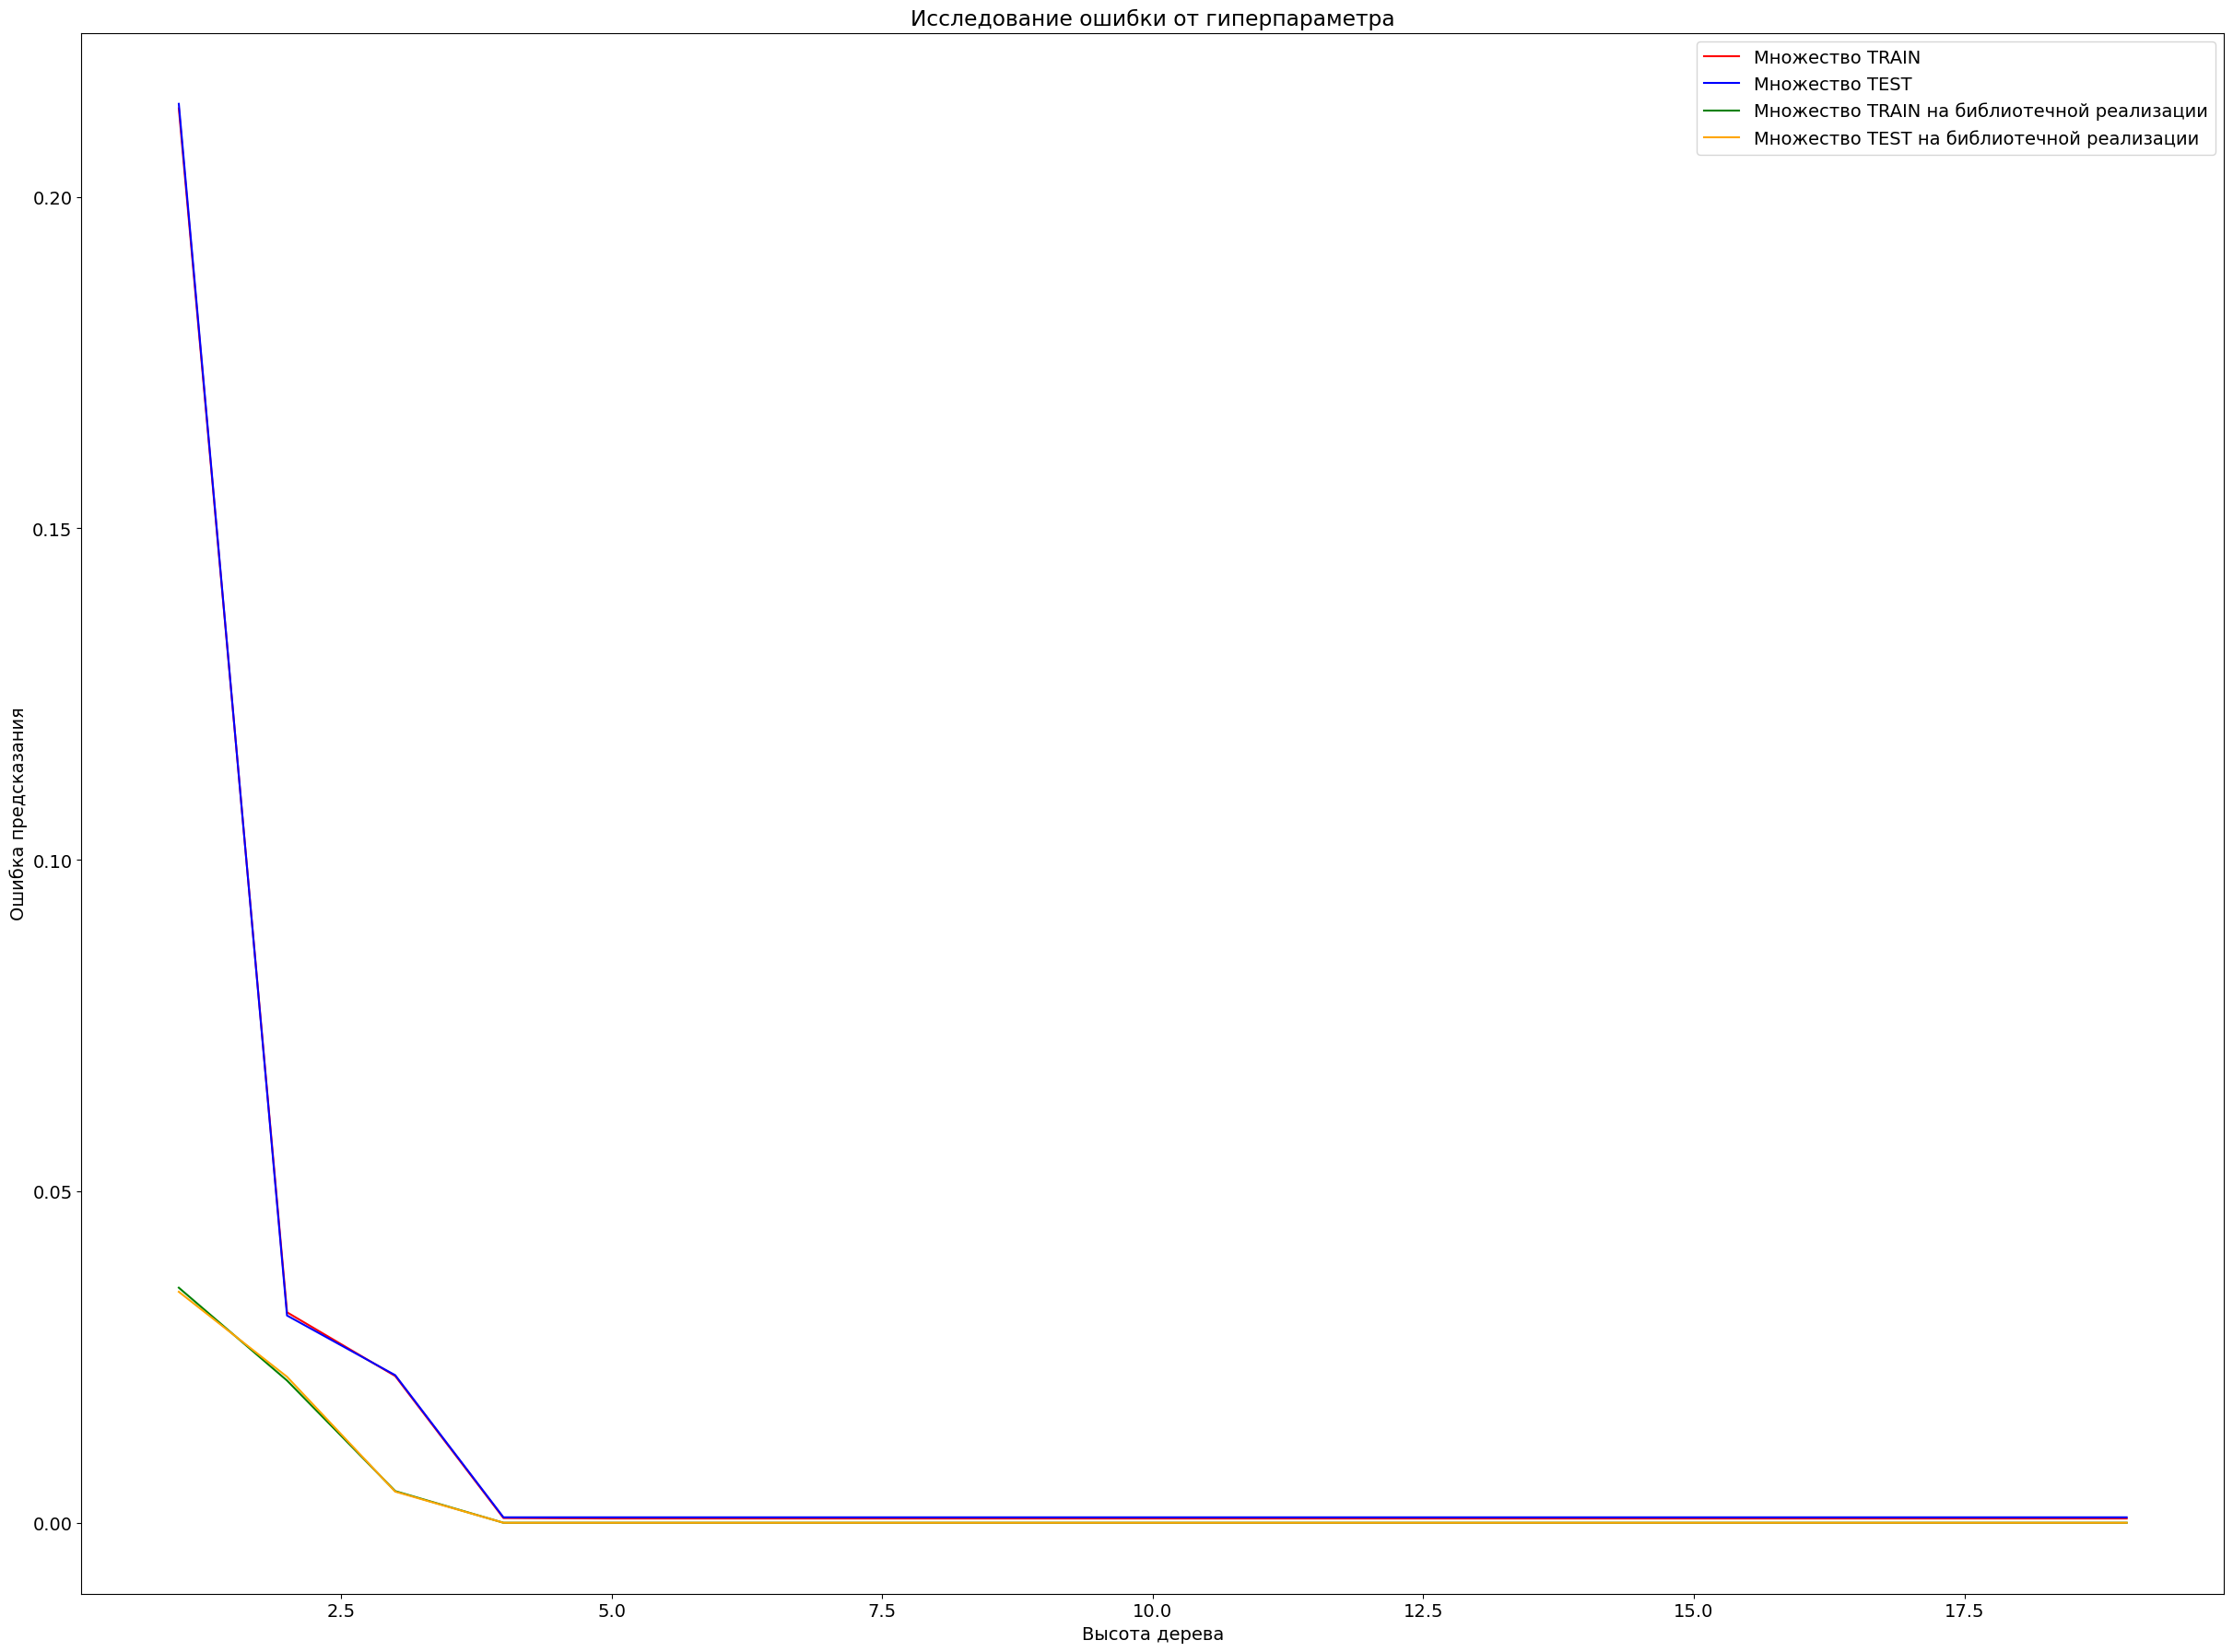

In [149]:
draw_errors("Высота дерева", errors_train, errors_test, errors_train_library, errors_test_library, heights)

#### Лучшие параметры для бустинга

##### Библиотечная реализация

In [125]:
def objective(trial: optuna.Trial) -> float:
	criterion = trial.suggest_categorical("criterion", ["entropy"])
	max_depth = trial.suggest_int("max_depth", 1, 20)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
	n_algorithms = trial.suggest_int("n_algorithms", 1, 10)
	model = BoostingWrapper(sklearn.tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf), n_algorithms = n_algorithms)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return sklearn.metrics.accuracy_score(y_test, pred)

In [126]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = OPTUNA_STUDY_N_TRIALS)

[I 2024-06-02 22:27:04,371] A new study created in memory with name: no-name-e21fc2e0-7fed-47ec-92ae-ee0e412c8578
[I 2024-06-02 22:27:04,427] Trial 0 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 71, 'n_algorithms': 8}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:27:04,476] Trial 1 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'n_algorithms': 9}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:27:04,521] Trial 2 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 35, 'n_algorithms': 2}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:27:04,564] Trial 3 finished with value: 0.9953060730704089 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'n_algorithms': 1}. Best is trial 0 with value: 1.0.
[I 2024-06-02 22:27:04,610] Trial 4 finished with value: 1.0 and parameters: {'criterion':

In [127]:
study.best_params

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 71,
 'n_algorithms': 8}

##### Своя реализация

In [150]:
def objective(trial: optuna.Trial) -> float:
	max_depth = trial.suggest_int("max_depth", 1, 20)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
	n_algorithms = trial.suggest_int("n_algorithms", 1, 10)
	model = Boosting(DecisionTree(entropy, max_depth = max_depth, min_samples_leaf = min_samples_leaf), n_algorithms = n_algorithms)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return sklearn.metrics.accuracy_score(y_test, pred)

In [151]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 3)

[I 2024-06-03 00:11:30,723] A new study created in memory with name: no-name-02cad4dc-a48f-4ba1-8855-e0ec608220d5
100%|██████████| 402/402 [00:00<00:00, 26445.47it/s]
/tmp/ipykernel_73154/2247239666.py:41: RuntimeWarning: overflow encountered in exp
  w_temp = numpy.array(self.__weights) * numpy.exp(-1 * self.__alphas[i] * numpy.array(y) * numpy.array(self.__weights))
100%|██████████| 30996/30996 [00:05<00:00, 5668.58it/s] 
[I 2024-06-03 00:28:53,098] Trial 0 finished with value: 0.9812242922816357 and parameters: {'max_depth': 4, 'min_samples_leaf': 90, 'n_algorithms': 8}. Best is trial 0 with value: 0.9812242922816357.
100%|██████████| 402/402 [00:00<00:00, 27509.47it/s]
[I 2024-06-03 00:29:53,253] Trial 1 finished with value: 0.9991773530123397 and parameters: {'max_depth': 4, 'min_samples_leaf': 7, 'n_algorithms': 1}. Best is trial 1 with value: 0.9991773530123397.
100%|██████████| 82/82 [00:00<00:00, 51486.97it/s]
/tmp/ipykernel_73154/2247239666.py:41: RuntimeWarning: overflow enc

In [152]:
study.best_params

{'max_depth': 4, 'min_samples_leaf': 7, 'n_algorithms': 1}

#### Лучшие параметры для случайного леса

##### Библиотечная реализация

In [130]:
def objective(trial: optuna.Trial) -> float:
	max_depth = trial.suggest_int("max_depth", 1, 5)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
	n_estimators = trial.suggest_int("n_estimators", 5, 10)
	model = RandomForestWrapper(max_depth, min_samples_leaf, n_estimators)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return sklearn.metrics.accuracy_score(y_test, pred)

In [133]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = OPTUNA_STUDY_N_TRIALS)

[I 2024-06-02 22:53:17,837] A new study created in memory with name: no-name-53d01f83-dae3-4438-90d7-0fd5b4c5d932
[I 2024-06-02 22:53:17,902] Trial 0 finished with value: 0.9651584805226228 and parameters: {'max_depth': 1, 'min_samples_leaf': 72, 'n_estimators': 5}. Best is trial 0 with value: 0.9651584805226228.
[I 2024-06-02 22:53:17,958] Trial 1 finished with value: 0.9651584805226228 and parameters: {'max_depth': 1, 'min_samples_leaf': 58, 'n_estimators': 5}. Best is trial 0 with value: 0.9651584805226228.
[I 2024-06-02 22:53:18,028] Trial 2 finished with value: 0.9963706750544399 and parameters: {'max_depth': 3, 'min_samples_leaf': 15, 'n_estimators': 10}. Best is trial 2 with value: 0.9963706750544399.
[I 2024-06-02 22:53:18,095] Trial 3 finished with value: 0.9791434793128478 and parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 8}. Best is trial 2 with value: 0.9963706750544399.
[I 2024-06-02 22:53:18,151] Trial 4 finished with value: 0.9978707960319381 and pa

In [134]:
study.best_params

{'max_depth': 4, 'min_samples_leaf': 21, 'n_estimators': 10}

##### Своя реализация

In [141]:
def objective(trial: optuna.Trial) -> float:
	max_depth = trial.suggest_int("max_depth", 1, 5)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
	n_estimators = trial.suggest_int("n_estimators", 5, 10)
	model = RandomForest(entropy, max_depth, min_samples_leaf, n_estimators = n_estimators)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return sklearn.metrics.accuracy_score(y_test, pred)

In [142]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)

[I 2024-06-02 23:27:11,681] A new study created in memory with name: no-name-19414eab-3e05-4449-b007-8f577224ad15
100%|██████████| 2532/2532 [00:00<00:00, 10025.61it/s]
[I 2024-06-02 23:27:46,759] Trial 0 finished with value: 0.794628599080571 and parameters: {'max_depth': 2, 'min_samples_leaf': 84, 'n_estimators': 9}. Best is trial 0 with value: 0.794628599080571.
100%|██████████| 30/30 [00:00<00:00, 51150.05it/s]
[I 2024-06-02 23:28:22,143] Trial 1 finished with value: 0.9392209049116864 and parameters: {'max_depth': 4, 'min_samples_leaf': 18, 'n_estimators': 10}. Best is trial 1 with value: 0.9392209049116864.
100%|██████████| 271/271 [00:00<00:00, 28641.24it/s]
[I 2024-06-02 23:28:55,350] Trial 2 finished with value: 0.9414468908782966 and parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 8}. Best is trial 2 with value: 0.9414468908782966.
100%|██████████| 1129/1129 [00:00<00:00, 21800.08it/s]
[I 2024-06-02 23:29:30,069] Trial 3 finished with value: 0.869876602951

In [143]:
study.best_params

{'max_depth': 3, 'min_samples_leaf': 80, 'n_estimators': 8}

#### Зависимость от числа деревьев

In [135]:
def get_random_forest_error(X_train: List[List[float]], y_train: List[int], X_test: List[List[float]], y_test: List[int], n_estimators: int):
	model = RandomForest(entropy, n_estimators = n_estimators)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return get_error(pred, y_test)

In [136]:
def get_random_forest_wrapper_error(X_train: List[List[float]], y_train: List[int], X_test: List[List[float]], y_test: List[int], n_estimators: int):
	model = RandomForestWrapper(n_estimators = n_estimators)
	model.fit(X_train, y_train)
	pred = model.predict_many(X_test)
	return get_error(pred, y_test)

In [137]:
errors_train: List[float] = []
errors_test: List[float] = []
errors_train_library: List[float] = []
errors_test_library: List[float] = []

In [138]:
estimators = list(range(1, 10))

In [139]:
for height in tqdm.tqdm(heights):
	errors_train.append(get_random_forest_error(X_train, y_train, X_train, y_train, height))
	errors_test.append(get_random_forest_error(X_train, y_train, X_test, y_test, height))
	errors_train_library.append(get_random_forest_wrapper_error(X_train, y_train, X_train, y_train, height))
	errors_test_library.append(get_random_forest_wrapper_error(X_train, y_train, X_test, y_test, height))

100%|██████████| 19/19 [27:00<00:00, 85.31s/it]


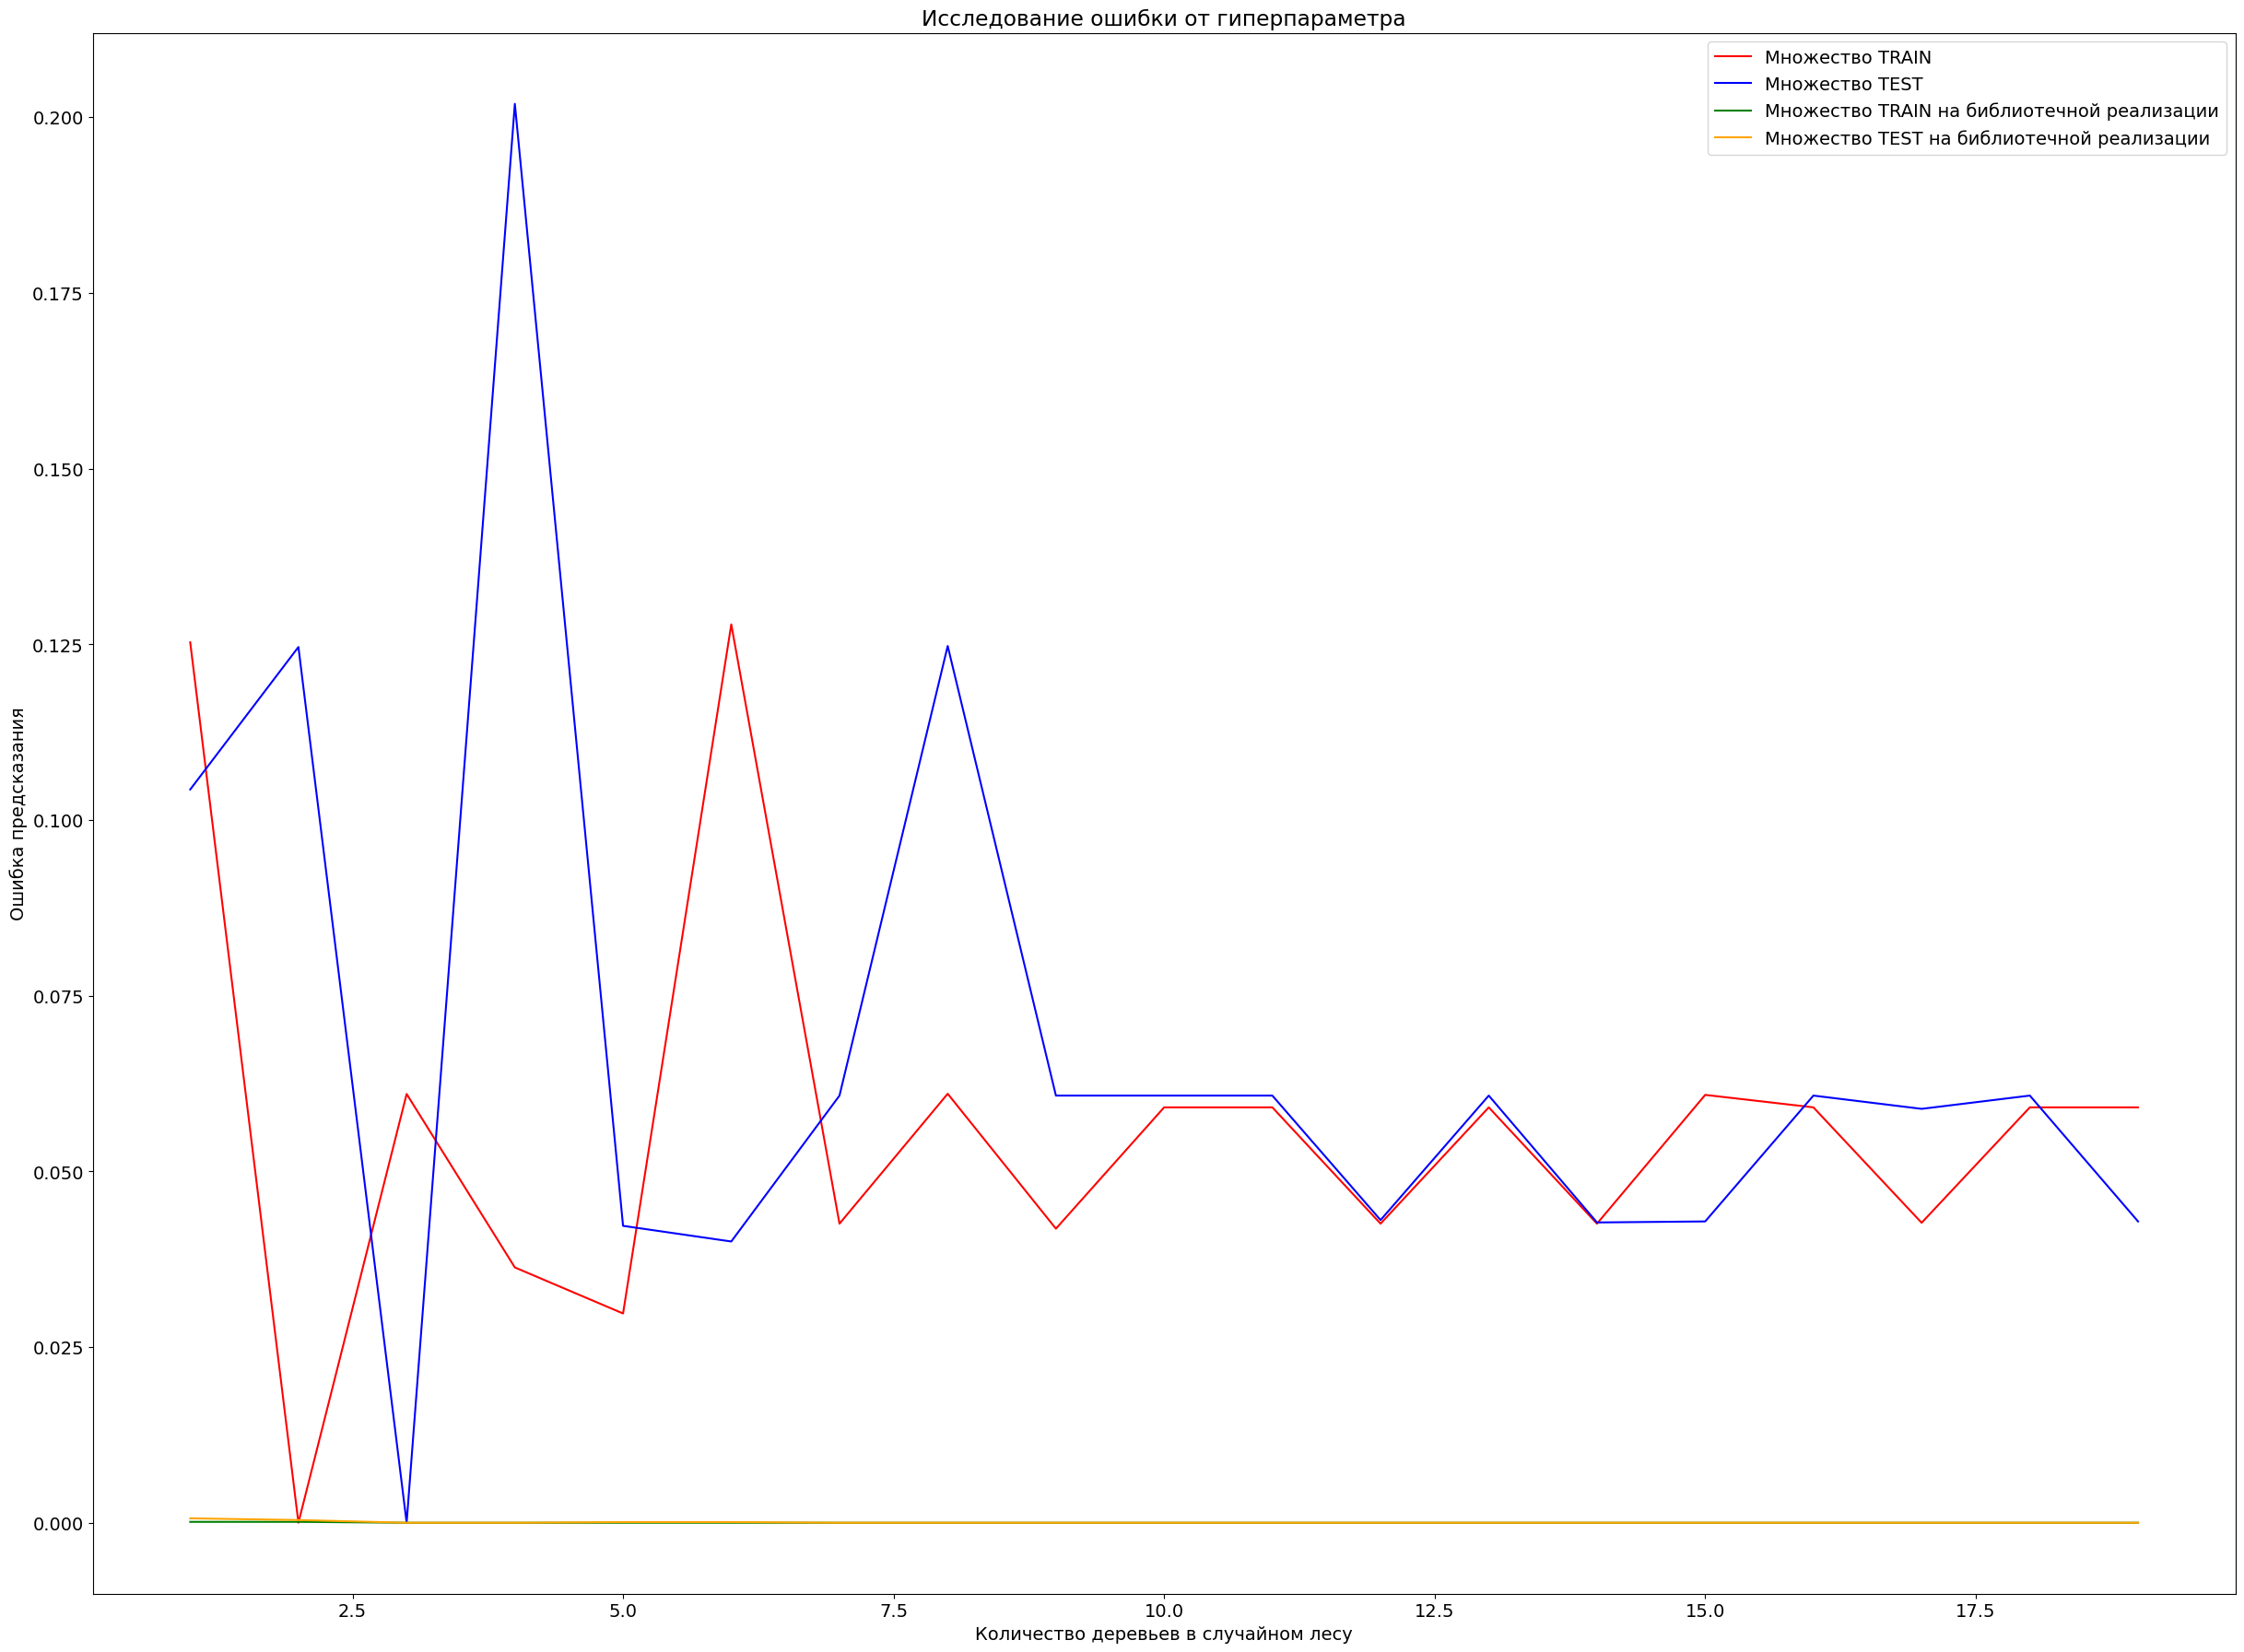

In [140]:
draw_errors("Количество деревьев в случайном лесу", errors_train, errors_test, errors_train_library, errors_test_library, heights)